In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d asad1m9a9h6mood/news-articles

Dataset URL: https://www.kaggle.com/datasets/asad1m9a9h6mood/news-articles
License(s): CC0-1.0


In [3]:
!unzip "news-articles.zip" -d "/content/dataset/"

Archive:  news-articles.zip
  inflating: /content/dataset/Articles.csv  


In [5]:
df = pd.read_csv("dataset/Articles.csv",encoding='unicode_escape')

In [6]:
df.head()

,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


In [7]:
df.shape

(2692, 4)

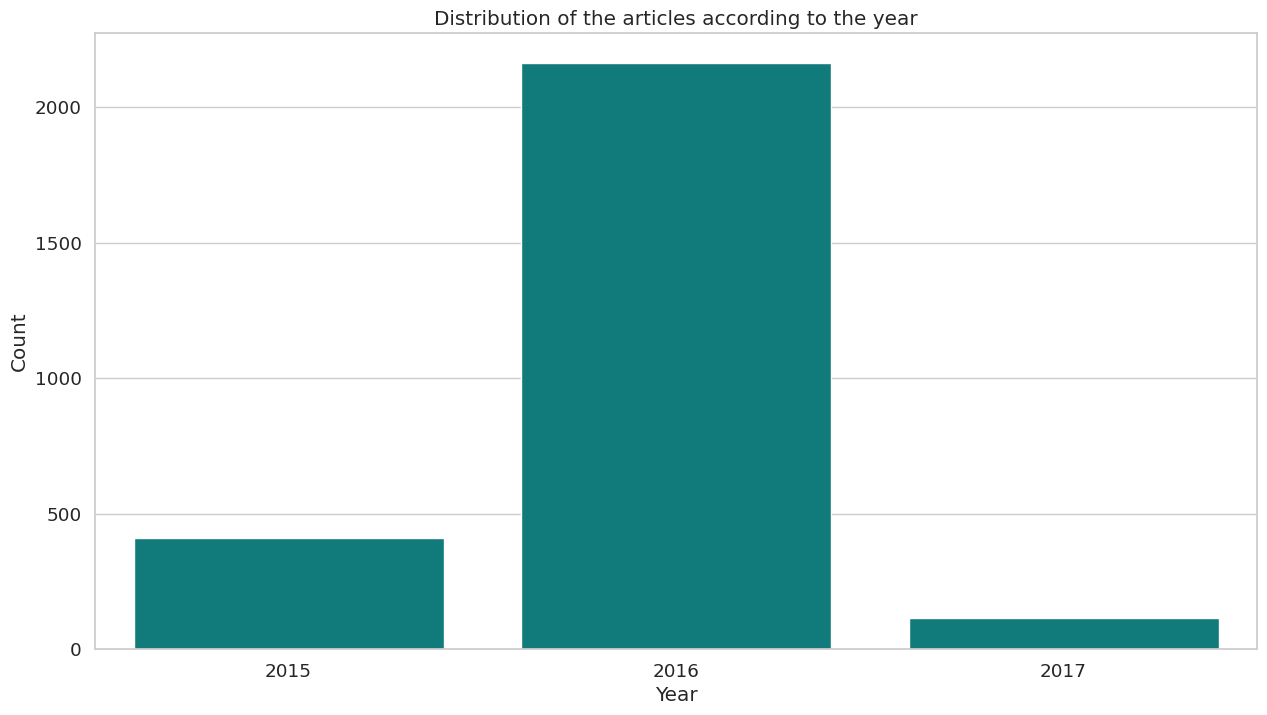

In [9]:
import seaborn as sns

# Convert the date column to datetime format (if not already)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # or try '%d/%m/%Y' if needed

# Extract year from the date
df['year'] = df['Date'].dt.year

# Plotting
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale=1.2, style='whitegrid')
sns_year = sns.countplot(x='year', data=df, color='darkcyan')
sns_year.set(xlabel="Year", ylabel="Count", title="Distribution of the articles according to the year")
plt.show()


In [12]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [16]:
import string
from string import punctuation
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'
from heapq import nlargest
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize

In [56]:
import re
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from heapq import nlargest

# Required downloads for NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Global constants
punctuation = string.punctuation
stop_words = set(stopwords.words('english'))

# Contractions dictionary
contractions_dict = {
    "can't": "cannot", "won't": "will not", "i'm": "i am", "it's": "it is", "he's": "he is",
    "she's": "she is", "they're": "they are", "we're": "we are", "you're": "you are",
    "i've": "i have", "you've": "you have", "we've": "we have", "they've": "they have",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "doesn't": "does not", "don't": "do not", "didn't": "did not", "hasn't": "has not",
    "haven't": "have not", "hadn't": "had not", "wouldn't": "would not", "shouldn't": "should not",
    "couldn't": "could not", "mightn't": "might not", "mustn't": "must not", "let's": "let us"
}
contractions_re = re.compile('(%s)' % '|'.join(re.escape(key) for key in contractions_dict.keys()))

# Clean HTML tags
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# Expand contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict.get(match.group(0), match.group(0))
    return contractions_re.sub(replace, text)

# Preprocessing function
def preprocessing(article):
    article = article.str.lower()
    article = article.apply(cleanhtml)
    article = article.apply(lambda x: re.sub('\S+@\S+', '', x))  # remove emails
    article = article.apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", '', x))  # remove URLs
    article = article.apply(lambda x: x.replace("\xa0", " "))
    article = article.apply(expand_contractions)
    article = article.apply(lambda x: re.sub(r"'s\b", '', x))
    article = article.apply(lambda x: re.sub(r'’s\b', '', x))
    article = article.apply(lambda x: re.sub(' +', ' ', x))

    # Keep a copy before punctuation and stopword removal
    article_sent_copy = article.copy()

    # Remove punctuation
    article = article.apply(lambda x: ''.join(ch for ch in x if ch not in punctuation))
    article = article.apply(lambda x: re.sub(' +', ' ', x))

    # Remove stopwords
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

    return article, article_sent_copy

# Normalize word frequencies
def normalize(frequencies_list):
    normalized_list = []
    for freq in frequencies_list:
        if freq:
            max_freq = max(freq.values())
            for word in freq:
                freq[word] /= max_freq
        normalized_list.append(freq)
    return normalized_list

# Word frequency function
def word_frequency(text_series):
    all_freqs = []
    for doc in text_series:
        freqs = {}
        for word in word_tokenize(doc):
            if word not in stop_words:
                freqs[word] = freqs.get(word, 0) + 1
        all_freqs.append(freqs)
    return normalize(all_freqs)

# Sentence scoring
def sentence_score(sentences_list, normalized_freqs):
    all_scores = []
    for sentences, freq in zip(sentences_list, normalized_freqs):
        scores = {}
        for sent in sentences:
            for word in word_tokenize(sent.lower()):
                if word in freq:
                    scores[sent] = scores.get(sent, 0) + freq[word]
        all_scores.append(scores)
    return all_scores

# Tokenize into sentences and score them
def sent_token(article_sentences, normalized_freqs):
    all_sentence_lists = []
    for article in article_sentences:
        sents = sent_tokenize(article)
        clean_sents = [' '.join(word for word in sent.split() if word not in punctuation) for sent in sents]
        all_sentence_lists.append(clean_sents)
    return sentence_score(all_sentence_lists, normalized_freqs)

# Summary function
def summary(sentence_scores):
    summaries = []
    for score_dict in sentence_scores:
        if not score_dict:
            summaries.append("")
            continue
        select_len = max(1, int(len(score_dict) * 0.10))
        top_sents = nlargest(select_len, score_dict, key=score_dict.get)
        summaries.append(". ".join(top_sents))
    return summaries
# Convert string to pandas Series
def make_series(article_text):
    return pd.Series([article_text])

# Final summarization function
def article_summarize(input_data):
    if not isinstance(input_data, pd.Series):
        input_data = make_series(input_data)

    preprocessed_text, raw_sentences = preprocessing(input_data)
    word_freqs = word_frequency(preprocessed_text)
    sentence_scores = sent_token(raw_sentences, word_freqs)
    return summary(sentence_scores)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
from wordcloud import WordCloud

In [58]:
# Generating the Word Cloud of the article using the preprocessing and make_series function mentioned below
def word_cloud(art):
    art_ = make_series(art)
    OwO = preprocessing(art_)
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(art)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off');
# Generating the summaries for the first 100 articles
summaries = article_summarize(df['Article'][0])

In [59]:
print ("The Actual length of the article is : ", len(df['Article'][1]))
df['Article'][1]

The Actual length of the article is :  4820


'HONG KONG: Asian markets started 2015 on an upswing in limited trading on Friday, with mainland Chinese stocks surging in Hong Kong on speculation Beijing may ease monetary policy to boost slowing growth.Hong Kong rose 1.07 percent, closing 252.78 points higher at 23857.82.Seoul closed up 0.57 percent, rising 10.85 points to 1,926.44, while Sydney gained 0.46 percent, or 24.89 points, to close at 5,435.9.Singapore edged up 0.19 percent, gaining 6.39 points to 3,371.54.Markets in mainland China, Japan, Taiwan, New Zealand, the Philippines, and Thailand remained closed for holidays.With mainland bourses shut until January 5, shares in Chinese developers and financial companies surged in Hong Kong, stoked by hopes that Beijing could ease monetary policy to support lagging growth in the world´s second-largest economy.China Vanke, the country´s biggest developer by sales, leapt 10.8 percent and the People´s Insurance Company (Group) of China Ltd. was up 5.51 percent in afternoon trading.Tr

In [60]:
summaries = article_summarize(df['Article'][0:4])
print ("The length of the summarized article is : ", len(summaries[1]))
summaries[1]

The length of the summarized article is :  1663


'hong kong: asian markets started 2015 on an upswing in limited trading on friday, with mainland chinese stocks surging in hong kong on speculation beijing may ease monetary policy to boost slowing growth.hong kong rose 1.07 percent, closing 252.78 points higher at 23857.82.seoul closed up 0.57 percent, rising 10.85 points to 1,926.44, while sydney gained 0.46 percent, or 24.89 points, to close at 5,435.9.singapore edged up 0.19 percent, gaining 6.39 points to 3,371.54.markets in mainland china, japan, taiwan, new zealand, the philippines, and thailand remained closed for holidays.with mainland bourses shut until january 5, shares in chinese developers and financial companies surged in hong kong, stoked by hopes that beijing could ease monetary policy to support lagging growth in the world´s second-largest economy.china vanke, the country´s biggest developer by sales, leapt 10.8 percent and the people´s insurance company (group) of china ltd. was up 5.51 percent in afternoon trading.tr